# Multivariate LTSM Time Series Forecasting Model for NASDAQ Market Predictions

In [2]:
#Install packages and import dependencies
!pip install yfinance

import math
import yfinance as yf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

#Set plot style
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})


In [3]:
# Creat dataset
start_date = '2000-01-01'
end_date = '2023-03-01'
stockname = 'NASDAQ'
ticker_symbol = '^IXIC'

dataset = yf.download(ticker_symbol, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


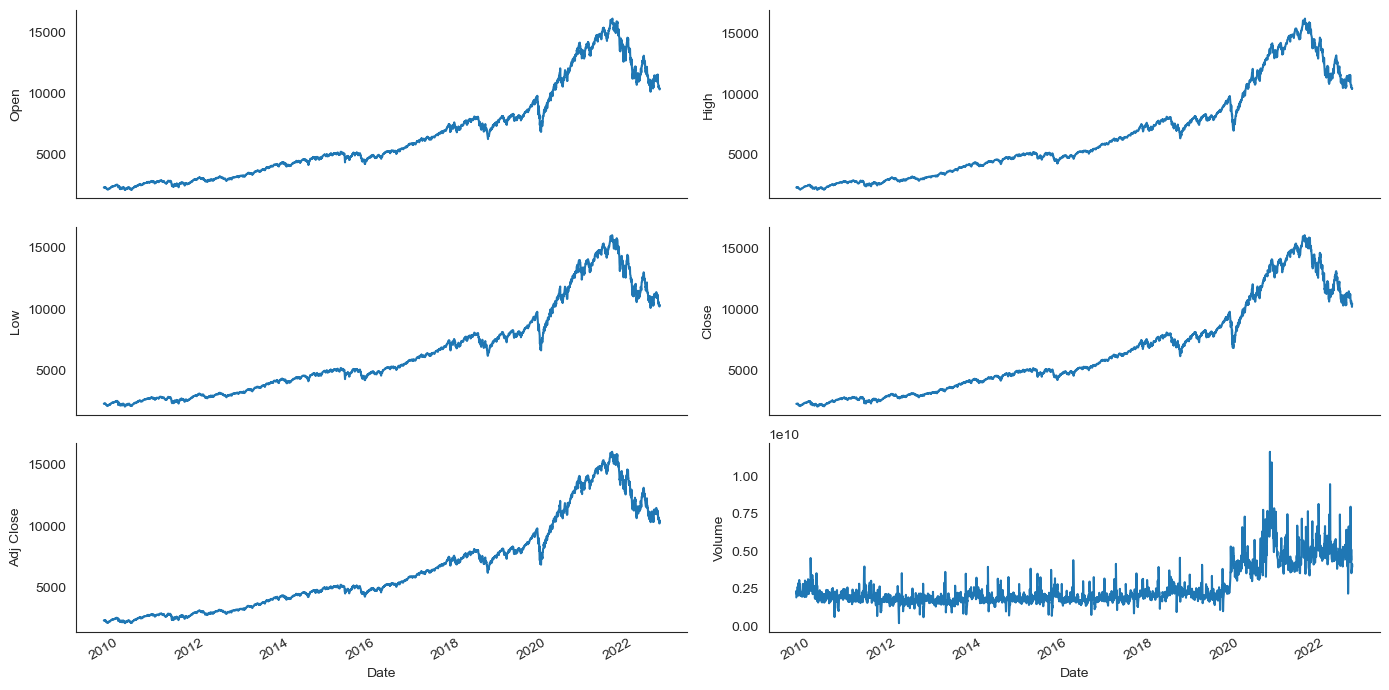

In [4]:
#Plot the market data
dataset.head()
dataset_plot = dataset.copy()
number_of_columns = 2
number_of_rows = int(round(dataset_plot.shape[1] / number_of_columns, 0))

fig, ax = plt.subplots(nrows=number_of_rows, ncols=number_of_columns, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
    sns.lineplot(data=dataset_plot.iloc[:, i], ax=ax)
    ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [5]:
# Preprocessing & feature selection

FEATURES_FILTER_LIST = ['High', 'Low', 'Open', 'Close', 'Volume']  # Features to use for training

# Create a new dataset containing only the selected features
data = pd.DataFrame(dataset.sort_values(by=['Date']).copy())
filtered_dataset = data[FEATURES_FILTER_LIST]

number_of_rows = filtered_dataset.shape[0]

# Add column for predictions and fill with tmp data before scaling
dataset_filtered_ext = filtered_dataset.copy()
dataset_filtered_ext['Prediction'] = dataset_filtered_ext['Close']

# load data into numpy array
np_data_unscaled = np.array(filtered_dataset)
np_data = np.reshape(np_data_unscaled, (number_of_rows, -1))

#Scale data 0-1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

#prediction scaler
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(dataset_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

In [6]:
#Print features, shape of data  & the tail of the filtered dataset
print('FEATURE LIST')
print([feature for feature in FEATURES_FILTER_LIST])

# print dataset tail
print(dataset_filtered_ext.tail())

#print the shape of the numpy array:
print("Shape of data:")
print(np_data.shape)


FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
                    High           Low          Open         Close  \
Date                                                                 
2022-12-23  10514.759766  10361.820312  10437.750000  10497.860352   
2022-12-27  10472.320312  10340.730469  10462.190430  10353.230469   
2022-12-28  10414.820312  10207.469727  10339.200195  10213.290039   
2022-12-29  10502.080078  10301.059570  10321.459961  10478.089844   
2022-12-30  10468.309570  10324.700195  10368.370117  10466.480469   

                Volume    Prediction  
Date                                  
2022-12-23  3544680000  10497.860352  
2022-12-27  3827290000  10353.230469  
2022-12-28  3842970000  10213.290039  
2022-12-29  4154100000  10478.089844  
2022-12-30  3959030000  10466.480469  
Shape of data:
(3272, 5)


In [7]:
#Model training

# Set the sequence length - this is the timeframe used to make a single prediction
window_size = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data



#train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

#todo get length from date

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

testing = np_data_scaled.

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - window_size:, :]


# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i - sequence_length:i, :])  # contains sequence_length values 0-sequence_length * columns
        y.append(data[i, index_Close])  # contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y


# Generate training data and test data
x_train, y_train = partition_dataset(window_size, train_data)
x_test, y_test = partition_dataset(window_size, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][window_size - 1][index_Close])
print(y_train[0])

# Model Training

# Configure the neural network model
model = Sequential()

# Model with n_neurons = input shape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Training the model
epochs = 500
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, start_from_epoch=10,restore_best_weights=True)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs, callbacks=[early_stop],
                    validation_data=(x_test, y_test)
                    )


# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

(2568, 50, 5) (2568,)
(654, 50, 5) (654,)
0.02128794868212508
0.02128794868212508
Metal device set to: Apple M1
250 50 5


2023-04-04 11:26:10.034834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-04 11:26:10.037720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TypeError: EarlyStopping.__init__() got an unexpected keyword argument 'start_from_epoch'

In [ ]:
# Evaluate Model Performance

# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred) / y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred) / y_test_unscaled))) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

# The date from which on the date is displayed
display_start_date = "2019-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(dataset_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(dataset_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3,
        label='residuals', color=df_sub)
plt.legend()
plt.show()

In [ ]:
#Save the predictions to file

file_name = 'LSTM_predictions_'+stockname +'_' +start_date +'_' +end_date +'_' +str(window_size) +'_'+str(batch_size) +'_'+ str(MAE) +'_' +str(MAPE) +'_' +str(MDAPE) + '.csv'


valid.to_csv(file_name, index=False)
